Code taken from :

https://github.com/SeokjuLee/Insta-DM/ <br/>
https://github.com/georgegach/flowiz/blob/master/flowiz/flowiz.py

In [1]:
import os
import numpy as np
import cv2
import torch
import quaternion
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm

In [18]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

def get_color(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    color_path = os.path.join(folder, "0", f"{side}_rgb", str(frame_index) + ".jpg")
    color = cv2.imread(color_path, -1)

    if do_flip:
        color = np.fliplr(color)

    return color

def get_depth(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    depth_path = os.path.join(folder, "0", f"{side}_depth", str(frame_index) + ".png")
    depth = cv2.imread(depth_path, -1).astype(np.float32) * 10 / 65535

    if do_flip:
        depth = np.fliplr(depth)

    return depth

def get_pose(folder, frame_index, side, do_flip):
    # Refer to registration_test notebook.
    
    baseline = 0.2
    cam_height = 1.0
    
    cam_to_agent = np.eye(4)
    cam_to_agent[1,1] = -1  # Flip the y-axis of the point-cloud to be pointing upwards
    cam_to_agent[2,2] = -1  # Flip the z-axis of the point-cloud to follow right-handed coordinate system.
    
    if side == 'r':
        cam_to_agent[:3, 3] = np.array([baseline/2, cam_height, 0])
    else:
        cam_to_agent[:3, 3] = np.array([-baseline/2, cam_height, 0])

    pose_path = os.path.join(folder, "0", "pose", str(frame_index) + ".npy")
    agent_pose = np.load(pose_path, allow_pickle=True).item()

    R = np.eye(4)
    R[:3, :3] = quaternion.as_rotation_matrix(agent_pose['rotation'])

    T = np.eye(4)
    T[:3, 3] = agent_pose['position']
    
    M = (T @ R @ cam_to_agent).astype(np.float32)

    # The images will already be locally flipped. 
    # We need to only flip the camera's global x-coordinate.
    # Refer to registration_notebook.
    M[0,3] *= (1 - 2*do_flip)

    return M

In [3]:
h, w = 480, 640
i_range = torch.arange(0, h).view(1, h, 1).expand(1,h,w)  # [1, H, W]
j_range = torch.arange(0, w).view(1, 1, w).expand(1,h,w)  # [1, H, W]
ones = torch.ones(1,h,w)

pixel_coords = torch.stack((j_range, i_range, ones), dim=1)  # [1, 3, H, W]

In [4]:
def check_sizes(input, input_name, expected):
    condition = [input.ndimension() == len(expected)]
    for i,size in enumerate(expected):
        if size.isdigit():
            condition.append(input.size(i) == int(size))
    assert(all(condition)), "wrong size for {}, expected {}, got  {}".format(input_name, 'x'.join(expected), list(input.size()))

In [5]:
def pose_vec2mat(vec, rotation_mode='euler'):
    """
    Convert 6DoF parameters to transformation matrix.
    Args:
        vec: 6DoF parameters in the order of tx, ty, tz, rx, ry, rz -- [B, 6]
    Returns:
        A transformation matrix -- [B, 3, 4]
    """
    translation = vec[:, :3].unsqueeze(-1)  # [B, 3, 1]
    rot = vec[:,3:]
    if rotation_mode == 'euler':
        rot_mat = euler2mat(rot)  # [B, 3, 3]
    elif rotation_mode == 'quat':
        rot_mat = quat2mat(rot)  # [B, 3, 3]
    transform_mat = torch.cat([rot_mat, translation], dim=2)  # [B, 3, 4]
    return transform_mat

In [6]:
def pixel2cam(depth, intrinsics_inv):
    """
    Transform coordinates in the pixel frame to the camera frame.
    Args:
        depth: depth maps -- [B, H, W]
        intrinsics_inv: intrinsics_inv matrix for each element of batch -- [B, 3, 3]
    Returns:
        array of (u,v,1) cam coordinates -- [B, 3, H, W]
    """
    b, h, w = depth.size()
    current_pixel_coords = pixel_coords[:,:,:h,:w].expand(b,3,h,w).reshape(b, 3, -1)    # [B, 3, H*W]
    cam_coords = (intrinsics_inv @ current_pixel_coords).reshape(b, 3, h, w)            # [B, 3, H, W]

    return cam_coords * depth.unsqueeze(1)

In [7]:
def cam2homo(cam_coords, proj_c2p_rot, proj_c2p_tr, padding_mode='zeros'):
    """
    Transform coordinates in the camera frame to the pixel frame.
    Args:
        cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]
        proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
        proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
    Returns:
        array of [-1,1] coordinates -- [B, 2, H, W]
    """
    b, _, h, w = cam_coords.size()
    cam_coords_flat = cam_coords.view(b, 3, -1)  # [B, 3, H*W]
    if proj_c2p_rot is not None:
        pcoords = proj_c2p_rot.bmm(cam_coords_flat)
    else:
        pcoords = cam_coords_flat

    if proj_c2p_tr is not None:
        pcoords = pcoords + proj_c2p_tr  # [B, 3, H*W]
    X = pcoords[:, 0]
    Y = pcoords[:, 1]
    Z = pcoords[:, 2].clamp(min=1e-3)

    X_homo = X / Z      # Homogeneous coords X
    Y_homo = Y / Z      # Homogeneous coords Y
    pixel_coords_homo = torch.stack([X_homo, Y_homo], dim=2)     # [B, H*W, 2]

    X_norm = 2*(X / Z)/(w-1) - 1  # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
    Y_norm = 2*(Y / Z)/(h-1) - 1  # Idem [B, H*W]
    if padding_mode == 'zeros':
        X_mask = ((X_norm > 1)+(X_norm < -1)).detach()
        X_norm[X_mask] = 2  # make sure that no point in warped image is a combination of im and gray
        Y_mask = ((Y_norm > 1)+(Y_norm < -1)).detach()
        Y_norm[Y_mask] = 2

    pixel_coords_norm = torch.stack([X_norm, Y_norm], dim=2)     # [B, H*W, 2]

    valid_points = pixel_coords_norm.view(b,h,w,2).abs().max(dim=-1)[0] <= 1
    valid_mask = valid_points.unsqueeze(1).float()

    return pixel_coords_homo.view(b,h,w,2), valid_mask

In [8]:
def depth2flow(depth, pose_mat, intrinsics, reverse_pose=False, rotation_mode='euler', padding_mode='zeros'):
    """
    Depth + Pose => Flow
    Args:
        img: the source image (where to sample pixels) -- [B, 3, H, W]
        depth: depth map of the target image -- [B, 1, H, W]
        pose_mat: transformation matrix from target to source -- [B, 3, 4]
        intrinsics: camera intrinsic matrix -- [B, 3, 3]
    Returns:
        Source image warped to the target image plane
    """
    check_sizes(depth, 'depth', 'B1HW')
    check_sizes(pose_mat, 'pose', 'B34')
    check_sizes(intrinsics, 'intrinsics', 'B33')

    batch_size, _, hh, ww = depth.size()    
    cam_coords = pixel2cam(depth.squeeze(1), intrinsics.inverse())  # D * K_inv * X, [B,3,H,W]
#     pose_mat = pose_vec2mat(pose, rotation_mode)  # RT, [B,3,4]

    if reverse_pose:
        aux_mat = torch.zeros([batch_size,4]).cuda().unsqueeze(1)
        aux_mat[:,:,3] = 1
        pose_mat = torch.cat([pose_mat, aux_mat], dim=1)    # [B, 4, 4]
        pose_mat = [t.inverse() for t in torch.functional.unbind(pose_mat)]
        pose_mat = torch.stack(pose_mat)                    # [B, 4, 4]
        pose_mat = pose_mat[:,:3,:]

    # Get projection matrix for tgt camera frame to source pixel frame
    proj_cam_to_src_pixel = intrinsics @ pose_mat                           # [B,3,4]
    rot, tr = proj_cam_to_src_pixel[:,:,:3], proj_cam_to_src_pixel[:,:,-1:]
    flow_grid, valid_mask = cam2homo(cam_coords, rot, tr, padding_mode)     # [B,H,W,2], [B,1,H,W]
    mgrid_np = np.expand_dims(np.mgrid[0:ww,0:hh].transpose(2,1,0).astype(np.float32),0).repeat(batch_size, axis=0)
    mgrid = torch.from_numpy(mgrid_np)                            # [B,H,W,2]
    
    flow_rigid = flow_grid - mgrid
    flow_rigid = flow_rigid.permute(0,3,1,2)

    return flow_rigid, valid_mask

In [9]:
TAG_FLOAT = 202021.25
flags = {
    'debug': False
}

def _color_wheel():
    # Original inspiration: http://members.shaw.ca/quadibloc/other/colint.htm

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])  # RGB

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0, RY, 1)/RY)
    col += RY

    # YG
    colorwheel[col: YG + col, 0] = 255 - \
        np.floor(255*np.arange(0, YG, 1)/YG)
    colorwheel[col: YG + col, 1] = 255
    col += YG

    # GC
    colorwheel[col: GC + col, 1] = 255
    colorwheel[col: GC + col, 2] = np.floor(255*np.arange(0, GC, 1)/GC)
    col += GC

    # CB
    colorwheel[col: CB + col, 1] = 255 - \
        np.floor(255*np.arange(0, CB, 1)/CB)
    colorwheel[col: CB + col, 2] = 255
    col += CB

    # BM
    colorwheel[col: BM + col, 2] = 255
    colorwheel[col: BM + col, 0] = np.floor(255*np.arange(0, BM, 1)/BM)
    col += BM

    # MR
    colorwheel[col: MR + col, 2] = 255 - \
        np.floor(255*np.arange(0, MR, 1)/MR)
    colorwheel[col: MR + col, 0] = 255

    return colorwheel


def _compute_color(u, v):
    colorwheel = _color_wheel()
    idxNans = np.where(np.logical_or(
        np.isnan(u),
        np.isnan(v)
    ))
    u[idxNans] = 0
    v[idxNans] = 0

    ncols = colorwheel.shape[0]
    radius = np.sqrt(np.multiply(u, u) + np.multiply(v, v))
    a = np.arctan2(-v, -u) / np.pi
    fk = (a+1) / 2 * (ncols - 1)
    k0 = fk.astype(np.uint8)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    img = np.empty([k1.shape[0], k1.shape[1], 3])
    ncolors = colorwheel.shape[1]

    for i in range(ncolors):
        tmp = colorwheel[:, i]
        col0 = tmp[k0] / 255
        col1 = tmp[k1] / 255
        col = (1-f) * col0 + f * col1
        idx = radius <= 1
        col[idx] = 1 - radius[idx] * (1 - col[idx])
        col[~idx] *= 0.75
        img[:, :, i] = np.floor(255 * col).astype(np.uint8)  # RGB
        # img[:, :, 2 - i] = np.floor(255 * col).astype(np.uint8) # BGR

    return img.astype(np.uint8)


def _normalize_flow(flow):
    UNKNOWN_FLOW_THRESH = 1e9
    # UNKNOWN_FLOW = 1e10

    height, width, nBands = flow.shape
    if not nBands == 2:
        raise AssertionError("Image must have two bands. [{h},{w},{nb}] shape given instead".format(
            h=height, w=width, nb=nBands))

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    # Fix unknown flow
    idxUnknown = np.where(np.logical_or(
        abs(u) > UNKNOWN_FLOW_THRESH,
        abs(v) > UNKNOWN_FLOW_THRESH
    ))
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max([-999, np.max(u)])
    maxv = max([-999, np.max(v)])
    minu = max([999, np.min(u)])
    minv = max([999, np.min(v)])

    rad = np.sqrt(np.multiply(u, u) + np.multiply(v, v))
    maxrad = max([-1, np.max(rad)])

    if flags['debug']:
        print("Max Flow : {maxrad:.4f}. Flow Range [u, v] -> [{minu:.3f}:{maxu:.3f}, {minv:.3f}:{maxv:.3f}] ".format(
            minu=minu, minv=minv, maxu=maxu, maxv=maxv, maxrad=maxrad
        ))

    eps = np.finfo(np.float32).eps
    u = u/(maxrad + eps)
    v = v/(maxrad + eps)

    return u, v


def _flow2color(flow):

    u, v = _normalize_flow(flow)
    img = _compute_color(u, v)

    return img


def _flow2uv(flow):
    u, v = _normalize_flow(flow)
    uv = (np.dstack([u, v])*127.999+128).astype('uint8')
    return uv

In [10]:
TAG_CHAR = np.array([TAG_FLOAT], np.float32)

def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if TAG_FLOAT != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            # Reshape data into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))

def writeFlow(filename,uv,v=None):
    """ Write optical flow to file.
    
    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    nBands = 2

    if v is None:
        assert(uv.ndim == 3)
        assert(uv.shape[2] == 2)
        u = uv[:,:,0]
        v = uv[:,:,1]
    else:
        u = uv

    assert(u.shape == v.shape)
    height,width = u.shape
    f = open(filename,'wb')
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width*nBands))
    tmp[:,np.arange(width)*2] = u
    tmp[:,np.arange(width)*2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()

In [16]:
def get_flow(scene_dir, idx1, idx2, min_depth=0.1, max_depth=10.0):
    K = camera_intrinsic_transform(320, 320, 320, 240)[:3, :3]
    
    depth1 = get_depth(scene_dir, idx1, 'l', False)
    depth1[depth1==0] = max_depth
    depth1 = np.clip(depth1, min_depth, max_depth)

    pose1 = get_pose(scene_dir, idx1, 'l', False)
    pose2 = get_pose(scene_dir, idx2, 'l', False)
    pose21 = (np.linalg.inv(pose2) @ pose1)[:3,:]
    
    b_depth = torch.from_numpy(depth1).view(1,1,*depth1.shape).float()
    b_K = torch.from_numpy(K).view(1,*K.shape).float()
    b_pose = torch.from_numpy(pose21).view(1,*pose21.shape).float()

    flow, mask = depth2flow(depth=b_depth, pose_mat=b_pose, intrinsics=b_K)

    flow = flow.squeeze(0).permute(1,2,0).numpy()
    
    mask = mask.squeeze(0).squeeze(0).numpy()
    
    return flow, mask

/scratch/shantanu/HabitatGibson/data/Allensville/0/left_depth/100.png


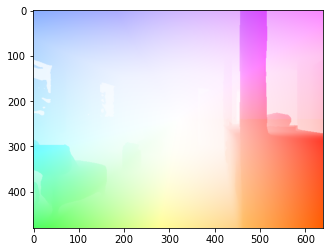

In [20]:
root_dir = '/scratch/shantanu/HabitatGibson/data'
scene = 'Allensville'
fileidx = 100
frame_id = 1

scene_dir = os.path.join(root_dir, scene)
idx1 = fileidx 
idx2 = fileidx + frame_id
flow, mask = get_flow(scene_dir, idx1, idx2)
flow_col = _flow2color(flow)
plt.imshow(flow_col)

In [21]:
def generate_scene_flow(fps):
    scene_dir, out_dir = fps.split()
    scene = os.path.basename(scene_dir)
    filenames = sorted(os.listdir(os.path.join(scene_dir, '0', 'pose')), key=lambda x: int(os.path.splitext(x)[0]))
    for i in range(0, len(filenames), 2):
        filename = filenames[i]
        idx1 = int(os.path.splitext(filename)[0])
        frame_ids = [-4, -2, 2, 4]
        for frame_id in frame_ids:
            idx2 = idx1 + frame_id
            if f'{idx2}.npy' not in filenames:
                continue

            flow, mask = get_flow(scene_dir, idx1, idx2)

            flow_save_path = os.path.join(out_dir, scene, '0', 'flow', f'f_{frame_id}', '{}.flo'.format(idx1))
            os.makedirs(os.path.dirname(flow_save_path), exist_ok=True)
            writeFlow(flow_save_path, flow)

            mask_save_path = os.path.join(out_dir, scene, '0', 'flow', f'm_{frame_id}', '{}.png'.format(idx1))
            os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
            cv2.imwrite(mask_save_path, mask)

In [22]:
out_dir = '/scratch/shantanu/HabitatGibson/flow'
scene_dirs = ['{} {}'.format(os.path.join(root_dir, scene), out_dir) for scene in os.listdir(root_dir)]

scene_dirs[:2]

['/scratch/shantanu/HabitatGibson/data/Darden /scratch/shantanu/HabitatGibson/flow',
 '/scratch/shantanu/HabitatGibson/data/Newfields /scratch/shantanu/HabitatGibson/flow']

In [23]:
generate_scene_flow(scene_dirs[0])

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/0.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/0.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/2.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/2.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/2.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/4.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/4.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/4.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/4.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/6.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/6.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/6.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/6.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/8.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/8.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_dept

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/66.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/66.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/66.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/68.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/68.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/68.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/68.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/70.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/70.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/70.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/70.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/72.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/72.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/72.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/72.png
/scratch/shantanu/HabitatGibson/data/Dar

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/130.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/130.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/130.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/132.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/132.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/132.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/132.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/134.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/134.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/134.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/134.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/136.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/136.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/136.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/136.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/194.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/194.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/194.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/194.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/196.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/196.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/196.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/196.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/198.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/198.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/198.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/198.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/200.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/200.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/200.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/256.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/258.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/258.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/258.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/258.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/260.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/260.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/260.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/260.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/262.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/262.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/262.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/262.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/264.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/264.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/320.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/320.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/322.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/322.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/322.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/322.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/324.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/324.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/324.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/324.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/326.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/326.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/326.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/326.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/328.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/384.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/384.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/384.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/386.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/386.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/386.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/386.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/388.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/388.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/388.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/388.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/390.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/390.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/390.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/390.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/448.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/448.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/448.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/448.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/450.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/450.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/450.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/450.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/452.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/452.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/452.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/452.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/454.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/454.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/454.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/510.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/512.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/512.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/512.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/512.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/514.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/514.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/514.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/514.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/516.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/516.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/516.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/516.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/518.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/518.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/574.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/574.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/576.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/576.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/576.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/576.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/578.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/578.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/578.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/578.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/580.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/580.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/580.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/580.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/582.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/638.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/638.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/640.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/640.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/640.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/640.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/642.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/642.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/642.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/642.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/644.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/644.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/644.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/644.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/646.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/702.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/702.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/704.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/704.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/704.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/704.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/706.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/706.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/706.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/706.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/708.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/708.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/708.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/708.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/710.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/766.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/766.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/766.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/768.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/768.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/768.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/768.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/770.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/770.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/770.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/770.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/772.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/772.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/772.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/772.png
/scratch/shantanu/Habitat

/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/830.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/830.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/830.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/832.png
/scratch/shantanu/HabitatGibson/data/Darden/0/left_depth/832.png


In [127]:
root_dir = '/scratch/shantanu/HabitatGibson/data'
out_dir = '/scratch/shantanu/HabitatGibson/flow'
flow_gen_args = []

scenes = os.listdir(root_dir)
for scene in scenes:
    scene_dir = os.path.join(root_dir, scene)
    filenames = sorted(os.listdir(os.path.join(scene_dir, '0', 'pose')), key=lambda x: int(os.path.splitext(x)[0]))

    for i in range(0, len(filenames), 2):
        filename = filenames[i]
        idx1 = int(os.path.splitext(filename)[0])
        frame_ids = [-3, -1, 1, 3]
        for frame_id in frame_ids:
            idx2 = idx1 + frame_id
            if f'{idx2}.npy' not in filenames:
                continue

            flow_gen_args.append(f'{root_dir} {scene} {idx1} {idx2} {out_dir}')

print(len(flow_gen_args))
flow_gen_args[:2]

50956


['/scratch/kinal.mehta/HabitatGibson/data Stockman 0 1 /scratch/kinal.mehta/HabitatGibson/flow',
 '/scratch/kinal.mehta/HabitatGibson/data Stockman 0 3 /scratch/kinal.mehta/HabitatGibson/flow']

In [128]:
def save_flow(args):
    root_dir, scene, idx1, idx2, out_dir = args.split()
    scene_dir = os.path.join(root_dir, scene)
    flow, mask = get_flow(scene_dir, idx1, idx2)
    
    frame_id = int(idx2) - int(idx1)

    flow_save_path = os.path.join(out_dir, scene, '0', 'flow', f'f_{frame_id}', '{}.flo'.format(idx1))
    os.makedirs(os.path.dirname(flow_save_path), exist_ok=True)
    writeFlow(flow_save_path, flow)

    mask_save_path = os.path.join(out_dir, scene, '0', 'flow', f'm_{frame_id}', '{}.png'.format(idx1))
    os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
    cv2.imwrite(mask_save_path, mask)

In [129]:
for arg in tqdm(flow_gen_args):
    save_flow(arg)

  0%|          | 0/50956 [00:00<?, ?it/s]